In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from scipy.io import mmread
import anndata as ad
import scipy
from tqdm import tqdm
import anndata
import random
from sklearn.metrics import adjusted_rand_score
# sc.settings.set_figure_params(dpi=400, transparent=True, format = 'eps')
random.seed(0)

In [2]:
sample_list=["scRNA_Seq_MEFXENCiPSC",
"scRNA_Seq_SIII_D10",
"scRNA_Seq_SIII_D15",
"scRNA_Seq_SIII_D21",
"scRNA_Seq_SIII_D3",
"scRNA_Seq_SIII_D6",
"scRNA_Seq_SIII_D8",
"scRNA_Seq_SII_D12",
"scRNA_Seq_SII_D8",
"scRNA_Seq_SI_D12",
"scRNA_Seq_SI_D5"]

# Gene

In [8]:
adata = sc.read('scRNA_Seq_MEFXENCiPSC/matrix.mtx',cache=True)
adata = adata.T
CB = pd.read_csv('scRNA_Seq_MEFXENCiPSC/barcodes.tsv',sep='\t',header = None)
Gene = pd.read_csv('scRNA_Seq_MEFXENCiPSC/features.tsv',sep='\t',header = None)
Gene = Gene[[1]]
adata.obs = CB
adata.var = Gene

adata.obs.columns = ['Cell_Barcode']
adata.obs = adata.obs.applymap(lambda x: str(x+'-ESCs'))
adata.obs.index = adata.obs['Cell_Barcode']
adata.var.columns = ['Gene']
adata.var.index = adata.var['Gene']

In [9]:
for sample in sample_list[1:]:    
    adata_tmp = sc.read(sample + '/matrix.mtx', cache=True)
    adata_tmp = adata_tmp.T
    CB = pd.read_csv(sample + '/barcodes.tsv',sep='\t',header = None)
    Gene = pd.read_csv(sample + '/features.tsv',sep='\t',header = None)
    Gene = Gene[[1]]
    adata_tmp.obs = CB
    adata_tmp.var = Gene

    adata_tmp.obs.columns = ['Cell_Barcode']
    adata_tmp.obs = adata_tmp.obs.applymap(lambda x: str(x+'-'+sample[10:]))
    adata_tmp.obs.index = adata_tmp.obs['Cell_Barcode']
    adata_tmp.var.columns = ['Gene']
    adata_tmp.var.index = adata_tmp.var['Gene']

    adata.var_names_make_unique()
    adata_tmp.var_names_make_unique()
    adata = ad.concat([adata,adata_tmp])

In [10]:
adata.obs['stage'] = adata.obs['Cell_Barcode'].apply(lambda x: x.split("-")[-1])

In [3]:
meta = pd.read_csv('../pData.csv')
meta = meta[['Barcode', 'Batch']]
meta['Barcode'] = meta['Barcode'].apply(lambda x: x.split('-')[0] )
meta.loc[meta['Batch'] == 'SI5D', 'Batch'] = 'SI_D5'  
meta.loc[meta['Batch'] == 'SI12D', 'Batch'] = 'SI_D12'  
meta.loc[meta['Batch'] == 'SII8D', 'Batch'] = 'SII_D8'  
meta.loc[meta['Batch'] == 'SII12D', 'Batch'] = 'SII_D12'  
meta.loc[meta['Batch'] == 'SIII3D', 'Batch'] = 'SIII_D3'  
meta.loc[meta['Batch'] == 'SIII6D', 'Batch'] = 'SIII_D6' 
meta.loc[meta['Batch'] == 'SIII8D', 'Batch'] = 'SIII_D8'  
meta.loc[meta['Batch'] == 'SIII10D', 'Batch'] = 'SIII_D10'  
meta.loc[meta['Batch'] == 'SIII15D', 'Batch'] = 'SIII_D15'  
meta.loc[meta['Batch'] == 'SIII21D', 'Batch'] = 'SIII_D21'
meta['stage'] = meta['Batch']
meta.loc[meta['stage'] == 'MEF', 'stage'] = 'ESCs'
meta.loc[meta['stage'] == 'XEN', 'stage'] = 'ESCs'
meta['Cell_Barcode'] = meta['Barcode']+ '-'+meta['stage']

In [12]:
obs = adata.obs
obs['stage'] = obs['Cell_Barcode'].apply(lambda x: x.split('-')[1])
obs.index.name='CB'
obs = obs.merge(meta,how = 'left', on =['Cell_Barcode','stage'])
obs.index = obs['Cell_Barcode']
obs = obs.reset_index(drop=True)
obs = obs[obs.Batch.notnull()]
notNa = obs.index
gene = adata.X[notNa,:]

In [13]:
var_names = adata.var.index.tolist()
var = pd.DataFrame(index=var_names)
X = gene
adata = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
adata.var["Gene"] = var.index.tolist()

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
adata.write('./MM10_Gene_raw.h5ad')

In [3]:
adata=sc.read('./MM10_Gene_raw.h5ad')

In [4]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

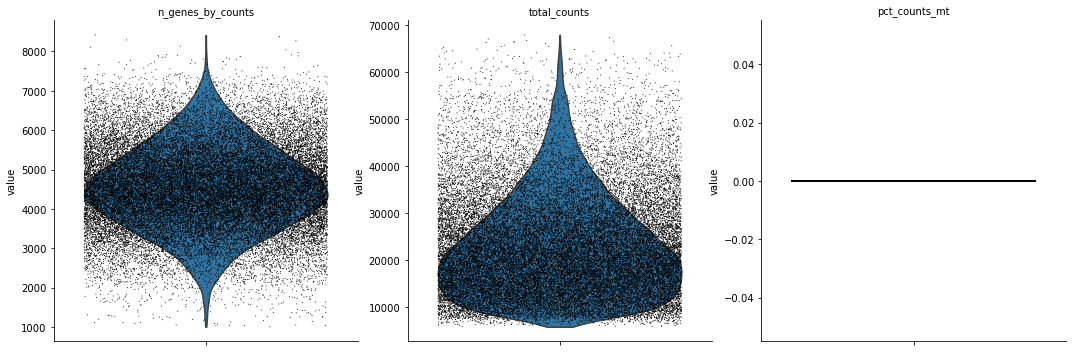

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

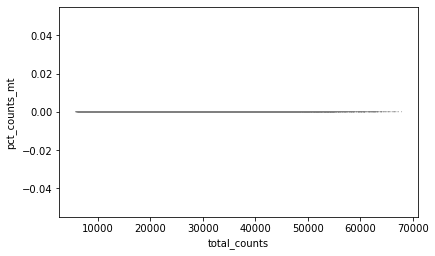

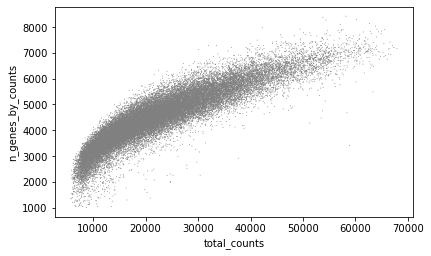

In [6]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\roxan\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\roxan\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


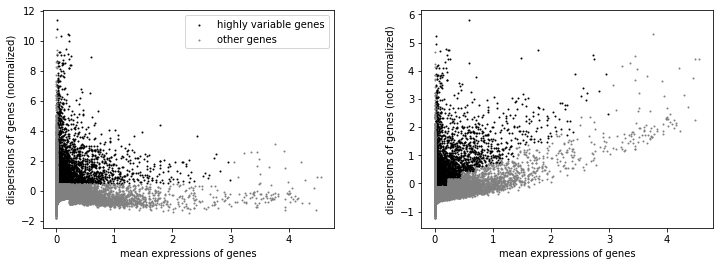

In [8]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

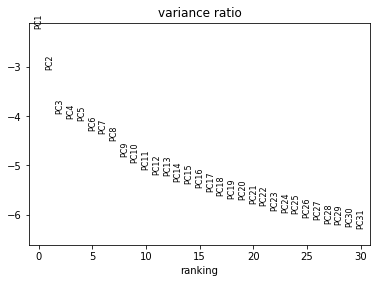

In [11]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
adata.write('./MM10_Gene.h5ad')

In [13]:
adata = sc.read_h5ad('./MM10_Gene.h5ad')

In [14]:
adata

AnnData object with n_obs × n_vars = 35925 × 3083
    obs: 'Cell_Barcode', 'stage', 'Barcode', 'Batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [22]:
random.seed(21)
randomlist = random.sample(range(0, 50), 15)

In [23]:
from sklearn.metrics.cluster import normalized_mutual_info_score
ari = []
nmi = []
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata, random_state = i)
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
    predict = adata.obs.leiden.tolist()
    true = adata.obs['Batch'].tolist()
    ari.append(adjusted_rand_score(predict, true))
    nmi.append(normalized_mutual_info_score(predict, true))

In [24]:
ari

[0.5288377257313646,
 0.5029088932302622,
 0.5162682141400543,
 0.5055470554149902,
 0.4713042400884845,
 0.5205690980064535,
 0.4741139021836982,
 0.5249460494622556,
 0.5217036996653753,
 0.5173805105846735,
 0.5208499790220054,
 0.5157901025177105,
 0.5150330619521484,
 0.5159091805922611,
 0.5179262377193024]

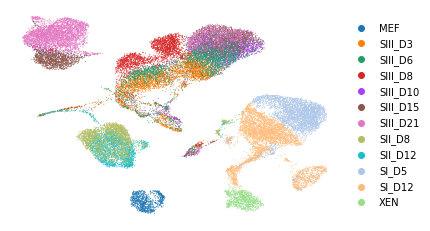

In [15]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)
sc.tl.leiden(adata, random_state = 15)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata,color = 'Batch', title = '',frameon=False)

In [24]:
adata = sc.read_h5ad('./MM10_Gene.h5ad')

In [25]:
tmp = adata.var.Gene.tolist()

In [26]:
len(tmp)

3083

# TE 

In [33]:
TE = pd.read_csv('scRNA_Seq_MEFXENCiPSC/TE_MTX.csv',index_col = 0)
TE.index.name='TE'
adata = sc.read('scRNA_Seq_MEFXENCiPSC/matrix.mtx',cache=True)
adata = adata.T
CB = pd.read_csv('scRNA_Seq_MEFXENCiPSC/barcodes.tsv',sep='\t',header = None)
Gene = pd.read_csv('scRNA_Seq_MEFXENCiPSC/features.tsv',sep='\t',header = None)
Gene =Gene[[1]]
CB = CB[CB[0].isin(TE.columns.tolist())]

idx = CB.index.tolist()
adata = adata[idx,:]
CB = CB.reset_index(drop = True)
adata.obs = CB
adata.var = Gene
adata.obs.columns = ['Cell_Barcode']
adata.obs = adata.obs.applymap(lambda x: str(x+'-ESCs'))
adata.var.columns = ['Gene']
adata.var.index = adata.var['Gene']

TE=TE[CB.Cell_Barcode.tolist()]
CB_tmp = [sub + '-ESCs' for sub in CB['Cell_Barcode'].tolist()]
TE.columns = CB_tmp

In [34]:
with tqdm(total = len(sample_list)-1) as pbar:
    for sample in sample_list[1:]:    
        adata_tmp = sc.read(sample + '/matrix.mtx',cache=True)
        adata_tmp = adata_tmp.T
        TE_tmp = pd.read_csv(sample + '/TE_MTX.csv',index_col = 0)
        TE_tmp.index.name='TE'
        CB = pd.read_csv(sample + '/barcodes.tsv',sep='\t',header = None)
        Gene = pd.read_csv(sample + '/features.tsv',sep='\t',header = None)
        Gene = Gene[[1]]
        CB = CB[CB[0].isin(TE_tmp.columns.tolist())]
        idx = CB.index.tolist()
        CB = CB.reset_index(drop = True)
        adata_tmp = adata_tmp[idx,:]
        adata_tmp.obs = CB
        adata_tmp.var = Gene

        adata_tmp.obs.columns = ['Cell_Barcode']
        adata_tmp.obs = adata_tmp.obs.applymap(lambda x: str(x+'-'+sample[10:]))
        adata_tmp.obs.index = adata_tmp.obs['Cell_Barcode']
        adata_tmp.var.columns = ['Gene']
        adata_tmp.var.index = adata_tmp.var['Gene']

        adata.var_names_make_unique()
        adata_tmp.var_names_make_unique()
        adata = ad.concat([adata,adata_tmp])
        
        TE_tmp = TE_tmp[CB['Cell_Barcode'].tolist()]
        
        CB_tmp = [sub + '-' + sample[10:] for sub in CB['Cell_Barcode'].tolist()]
        TE_tmp.columns = CB_tmp
        TE=pd.concat([TE, TE_tmp], axis=1)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


In [6]:
TE=TE.fillna(0)

In [35]:
obs = adata.obs
obs['stage'] = obs['Cell_Barcode'].apply(lambda x: x.split('-')[1])
obs.index.name='CB'
obs = obs.merge(meta,how = 'left', on =['Cell_Barcode','stage'])
obs.index = obs['Cell_Barcode']
obs = obs.reset_index(drop=True)
obs = obs[obs.Batch.notnull()]
notNa = obs.index
X = TE.T.values
X = X[notNa,:]

In [8]:
var_names = TE.index
var = pd.DataFrame(index=var_names)

adata_unique = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
adata_unique.var["TE"] = TE.index.tolist()

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


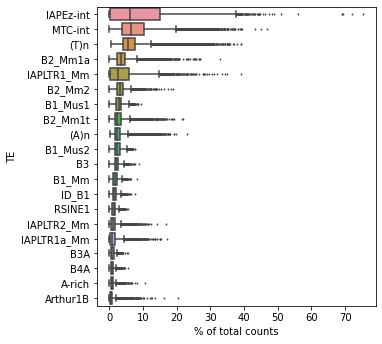

In [9]:
sc.pl.highest_expr_genes(adata_unique, n_top=20)

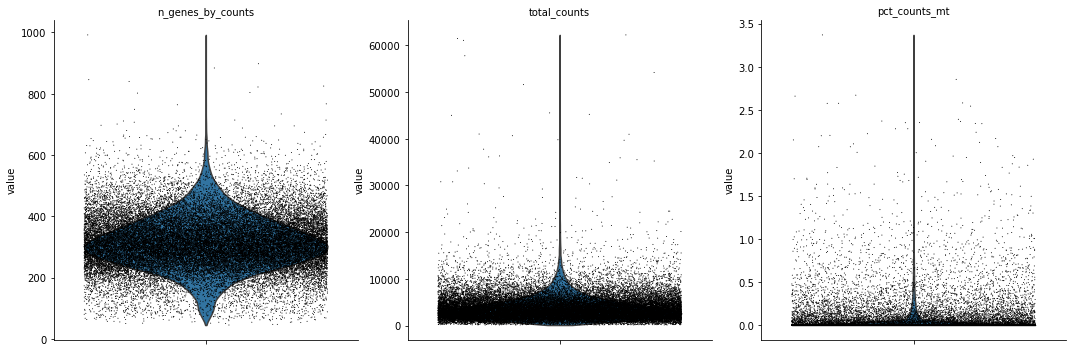

In [10]:
adata_unique.var['mt'] = adata_unique.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_unique, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_unique, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

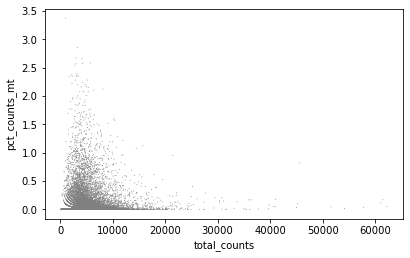

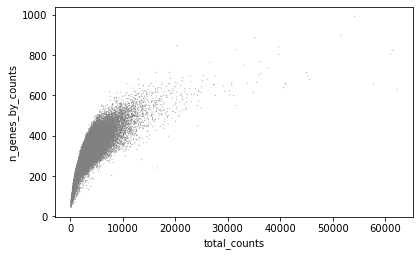

In [11]:
sc.pl.scatter(adata_unique, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_unique, x='total_counts', y='n_genes_by_counts')

In [12]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata_unique, target_sum=10**4)
# Replace raw counts with their logarithm
sc.pp.log1p(adata_unique)

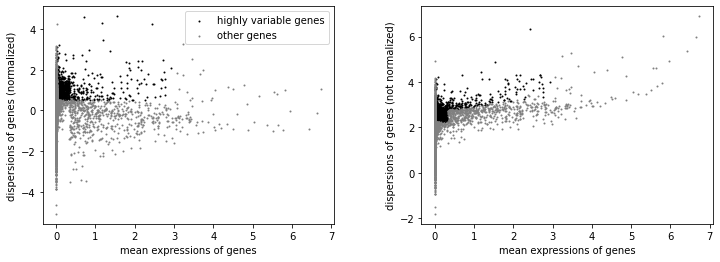

In [13]:
sc.pp.highly_variable_genes(adata_unique)
sc.pl.highly_variable_genes(adata_unique)

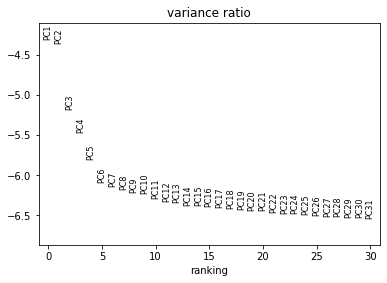

In [14]:
adata_unique.raw = adata_unique
adata_unique = adata_unique[:, adata_unique.var.highly_variable]
sc.pp.regress_out(adata_unique, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_unique, max_value=10)
sc.tl.pca(adata_unique, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_unique, log=True)

In [36]:
+random.seed(21)
randomlist = random.sample(range(0, 50), 15)
from sklearn.metrics.cluster import normalized_mutual_info_score
ari = []
nmi = []
sc.pp.neighbors(adata_unique, n_neighbors=15, n_pcs=15)
for i in randomlist:
    sc.tl.leiden(adata_unique, random_state = i)
    sc.tl.paga(adata_unique)
    sc.pl.paga(adata_unique, plot=False)
    sc.tl.umap(adata_unique, init_pos='paga')
    predict = adata_unique.obs.leiden.tolist()
    true = adata_unique.obs['Batch'].tolist()
    ari.append(adjusted_rand_score(predict, true))
    nmi.append(normalized_mutual_info_score(predict, true))

In [37]:
ari

[0.2631722492147496,
 0.24054252712212135,
 0.26883124393905566,
 0.25927696410646317,
 0.25950370690706676,
 0.26052618094567653,
 0.2719486988888459,
 0.2660234234651484,
 0.2513482173152986,
 0.2633199663248375,
 0.27082758917217525,
 0.260653894275566,
 0.27577790754396087,
 0.26397903106220344,
 0.2703970365668081]

In [20]:
nmi

[0.3878346362596711,
 0.3683123423601922,
 0.3839451481027553,
 0.3685538342531684,
 0.37736041980052054,
 0.36469966934165526,
 0.3836591552185859,
 0.38105522342130066,
 0.3776834475189961,
 0.3724913700982578,
 0.3794399973836051,
 0.38203623009227866,
 0.3840384496687014,
 0.3853582566884339,
 0.3826593590407179]

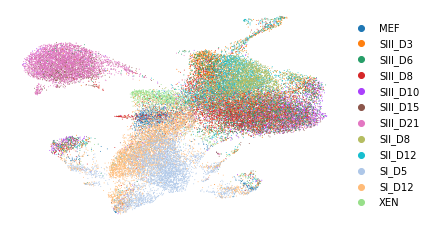

In [15]:
sc.pp.neighbors(adata_unique, n_neighbors=15, n_pcs=15)
sc.tl.leiden(adata_unique, random_state =0)
sc.tl.paga(adata_unique)
sc.pl.paga(adata_unique, plot=False)
sc.tl.umap(adata_unique, init_pos='paga')
sc.pl.umap(adata_unique,color = 'Batch', title = '',frameon=False)

In [21]:
# sc.pp.scale(adata_tmp,max_value=10)
sc.tl.rank_genes_groups(adata_unique, groupby='Batch', method='wilcoxon')

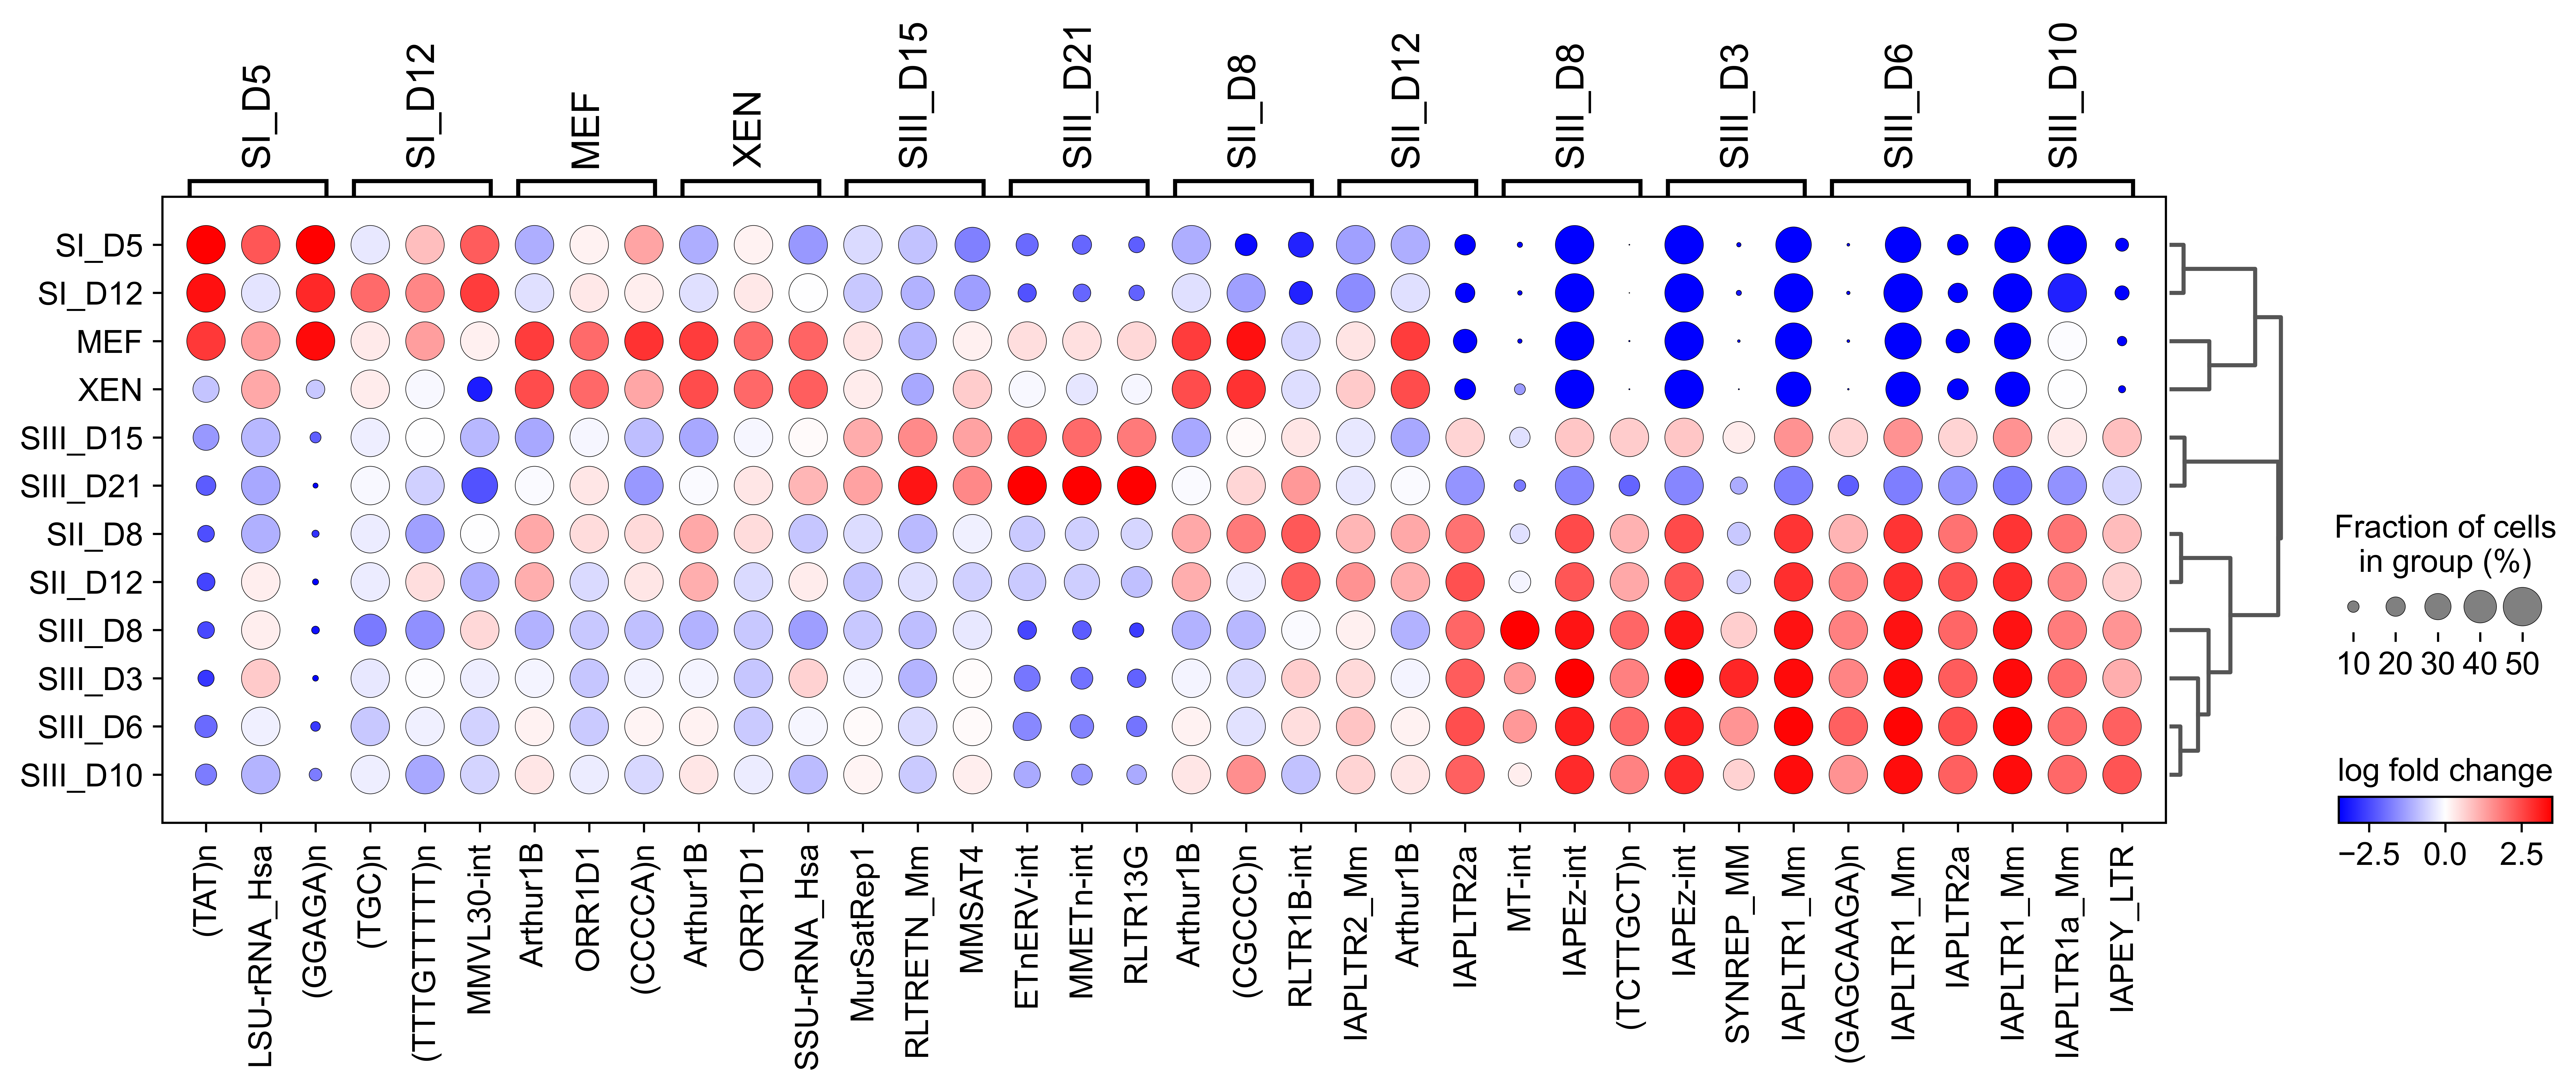

In [22]:
sc.pl.rank_genes_groups_dotplot(adata_unique, n_genes=3, min_logfoldchange=1, values_to_plot='logfoldchanges', dot_max = 0.5, vmax=3.5, vmin=-3.5, cmap='bwr', save = '')

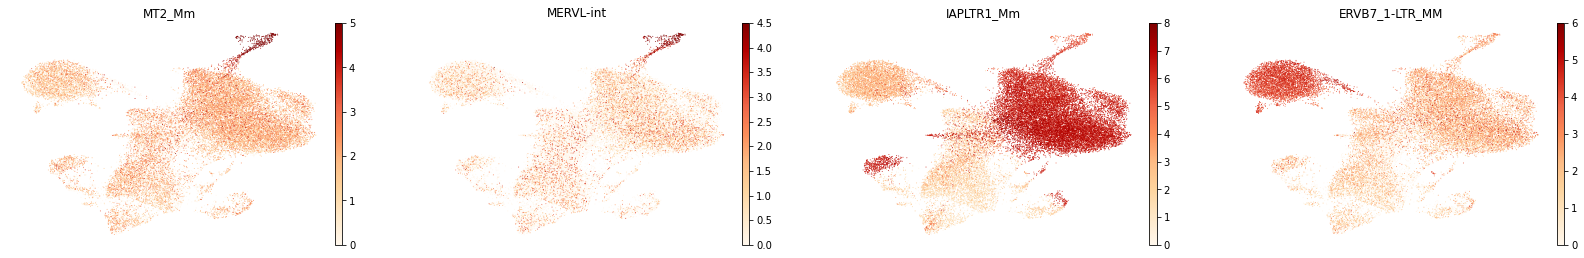

In [16]:
sc.pl.umap(adata_unique, color=['MT2_Mm','MERVL-int', 'IAPLTR1_Mm','ERVB7_1-LTR_MM'], vmax = [5,4.5,8,6], color_map = 'OrRd', frameon = False)

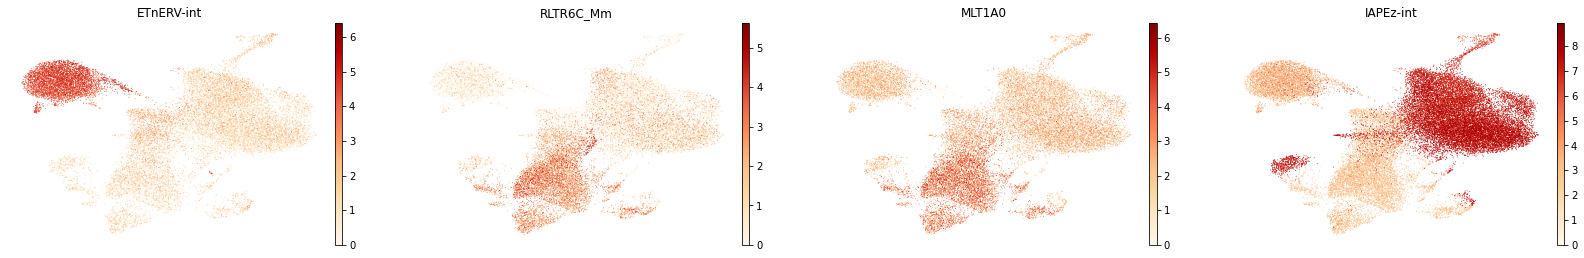

In [17]:
sc.pl.umap(adata_unique, color=['ETnERV-int', 
                                'RLTR6C_Mm','MLT1A0','IAPEz-int'], frameon = False, color_map = 'OrRd')

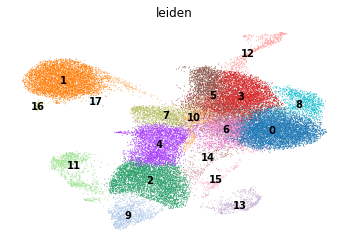

In [18]:
sc.pl.umap(adata_unique, color=['leiden'], legend_fontsize = 10, legend_loc = 'on data',frameon = False)

In [21]:
random.seed(21)
randomlist = random.sample(range(0, 50), 15)
from sklearn.metrics.cluster import normalized_mutual_info_score
ari = []
nmi = []
sc.pp.neighbors(adata_unique, n_neighbors=25, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata_unique, random_state = i)
    sc.tl.paga(adata_unique)
    sc.pl.paga(adata_unique, plot=False)
    sc.tl.umap(adata_unique, init_pos='paga')
    predict = adata_unique.obs.leiden.tolist()
    true = adata_unique.obs['Batch'].tolist()
    ari.append(adjusted_rand_score(predict, true))
    nmi.append(normalized_mutual_info_score(predict, true))

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> adde

In [22]:
ari

[0.2441231435615955,
 0.24707670305129012,
 0.24190209600357954,
 0.24378823274958225,
 0.2501317574328656,
 0.268545186332261,
 0.2492200382464794,
 0.2535518121995874,
 0.25087333215055496,
 0.2481180511972046,
 0.24483713840169202,
 0.2561876554404681,
 0.2507356269195576,
 0.2507474385520475,
 0.24524375038549664]

In [39]:
adata_unique

AnnData object with n_obs × n_vars = 35957 × 1180
    obs: 'Cell_Barcode', 'stage', 'Barcode', 'Batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'TE', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'Batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

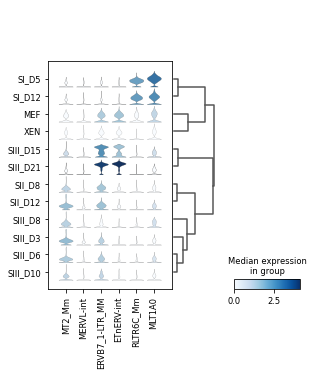

In [19]:
markers = ['MT2_Mm', 'MERVL-int', 'ERVB7_1-LTR_MM', 'ETnERV-int', 
                                'RLTR6C_Mm','MLT1A0']
sc.pl.stacked_violin(adata_unique, markers, groupby='Batch', dendrogram=True)

# Gene+TE

In [36]:
sparse = adata.X

In [37]:
i = adata_unique.var.index.tolist()

In [38]:
i.append('IAPLTR1_Mm')

In [39]:
var = adata.var
var['Gene'] = var.index
var = var.reset_index(drop=True)
var = var[var['Gene'].isin(tmp)]
newvar = var.index
sparse = sparse[:,newvar]
var.index=var['Gene']
var.index.name='Gene'
TE=TE[TE.index.isin(i)]
TE_sparse = scipy.sparse.csr_matrix(TE.T.values)

In [40]:
# Full = scipy.sparse.hstack((sparse, TE.T.values))

In [41]:
Full = scipy.sparse.hstack((sparse, TE_sparse))
Full = Full.tocsr()

In [42]:
Full.shape

(35957, 4264)

In [43]:
obs = adata.obs
obs['stage'] = obs['Cell_Barcode'].apply(lambda x: x.split('-')[1])
obs.index.name='CB'
obs = obs.merge(meta,how = 'left', on =['Cell_Barcode','stage'])
obs.index = obs['Cell_Barcode']
obs = obs.reset_index(drop=True)
obs = obs[obs.Batch.notnull()]
notNa = obs.index
Full = Full[notNa,:]

In [44]:
# var = adata.var

In [45]:
# var_names = var.index.tolist() + TE.index.tolist()
# var = pd.DataFrame(index=var_names)
# X = Full
# adata_full = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
# adata_full.var["Gene"] = var.index.tolist()
var_names = var.index.tolist() + TE.index.tolist()
var = pd.DataFrame(index=var_names)
X = Full
adata_full = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
adata_full.var["Gene"] = var.index.tolist()

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [47]:
sc.pp.filter_cells(adata_full, min_genes=1000)
sc.pp.filter_genes(adata_full, min_cells=10)

In [ ]:
adata_full.var['mt'] = adata_full.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_full = adata_full[adata_full.obs.pct_counts_mt < 20, :]
sc.pl.violin(adata_full, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata_full, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_full, x='total_counts', y='n_genes_by_counts')

In [72]:
# adata_full = adata_full[adata_full.obs.n_genes_by_counts < 2500, :]
# adata_full = adata_full[adata_full.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)
sc.pp.highly_variable_genes(adata_full, n_top_genes = 4000)
sc.pl.highly_variable_genes(adata_full)

In [ ]:
adata_full.raw = adata_full
adata_full = adata_full[:, adata_full.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata_full, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_full, max_value=10)
sc.tl.pca(adata_full, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_full, log=True)

In [66]:
random.seed(21)
randomlist = random.sample(range(0, 50), 15)
from sklearn.metrics.cluster import normalized_mutual_info_score
ari = []
nmi = []
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata_full, random_state = i)
    sc.tl.paga(adata_full)
    sc.pl.paga(adata_full, plot=False)
    sc.tl.umap(adata_full, init_pos='paga')
    predict = adata_full.obs.leiden.tolist()
    true = adata_full.obs['Batch'].tolist()
    ari.append(adjusted_rand_score(predict, true))
    nmi.append(normalized_mutual_info_score(predict, true))

In [49]:
adata_full.write_h5ad('../10X_processed.h5ad')

In [48]:
adata_full= sc.read_h5ad('../10X_processed.h5ad')

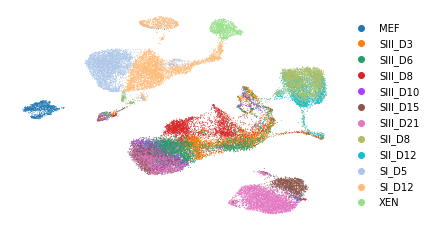

In [49]:
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
sc.tl.leiden(adata_full, random_state =0)
sc.tl.paga(adata_full)
sc.pl.paga(adata_full, plot=False)
sc.tl.umap(adata_full, init_pos='paga')
sc.pl.umap(adata_full,color = ['Batch'], title = '',frameon=False)

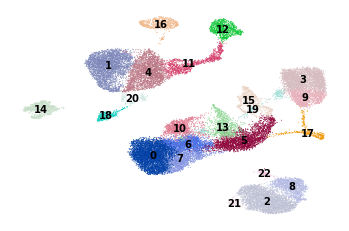

In [50]:
sc.pl.umap(adata_full,color = 'leiden', title = '',frameon=False, legend_fontsize = 10,legend_loc = 'on data')

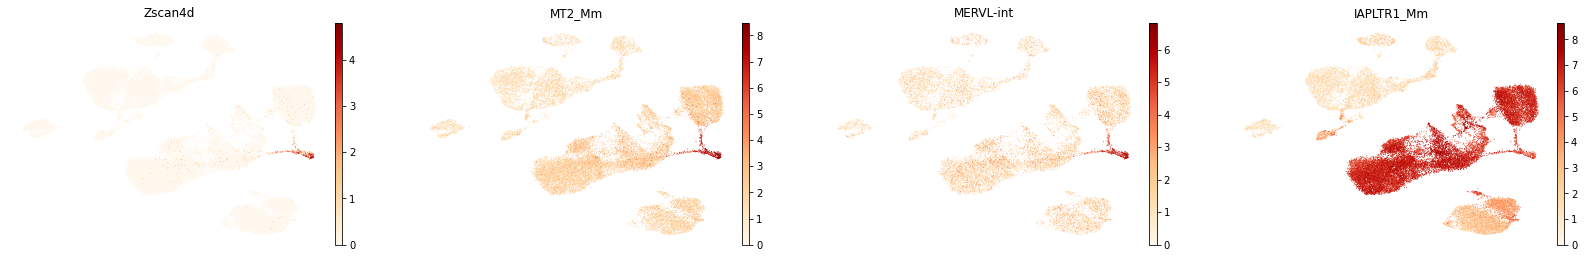

In [51]:
sc.pl.umap(adata_full, color=['Zscan4d','MT2_Mm','MERVL-int', 'IAPLTR1_Mm'], color_map = 'OrRd', frameon = False)

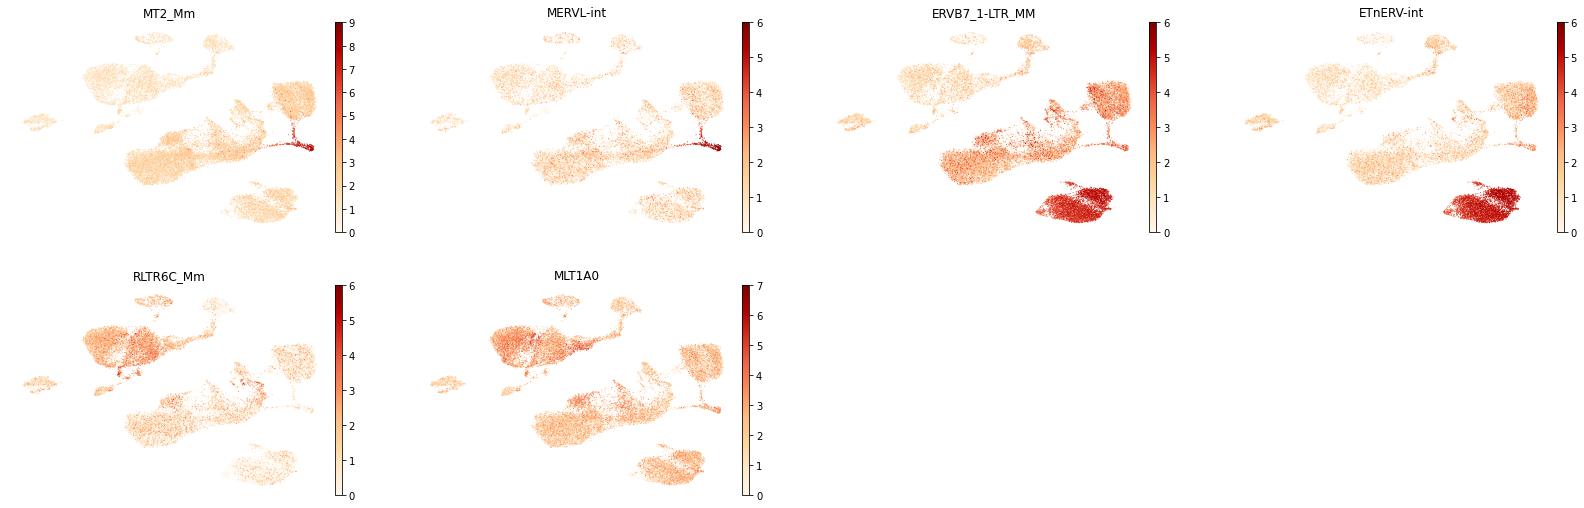

In [52]:
sc.pl.umap(adata_full, color=['MT2_Mm', 'MERVL-int', 'ERVB7_1-LTR_MM', 'ETnERV-int', 
                                'RLTR6C_Mm','MLT1A0'] , vmax = [9,6,6,6,6,7],frameon = False, color_map = 'OrRd')

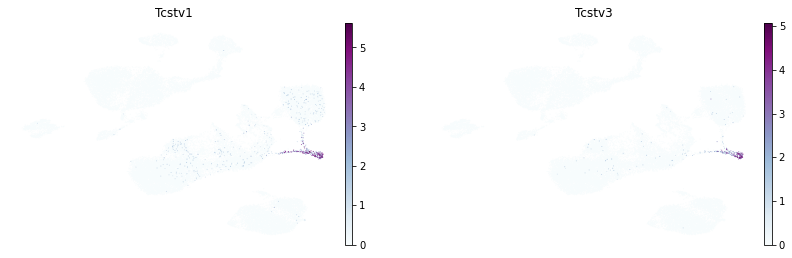

In [53]:
sc.pl.umap(adata_full, color=[ 'Tcstv1', 'Tcstv3'
                            ], frameon = False, color_map = 'BuPu')

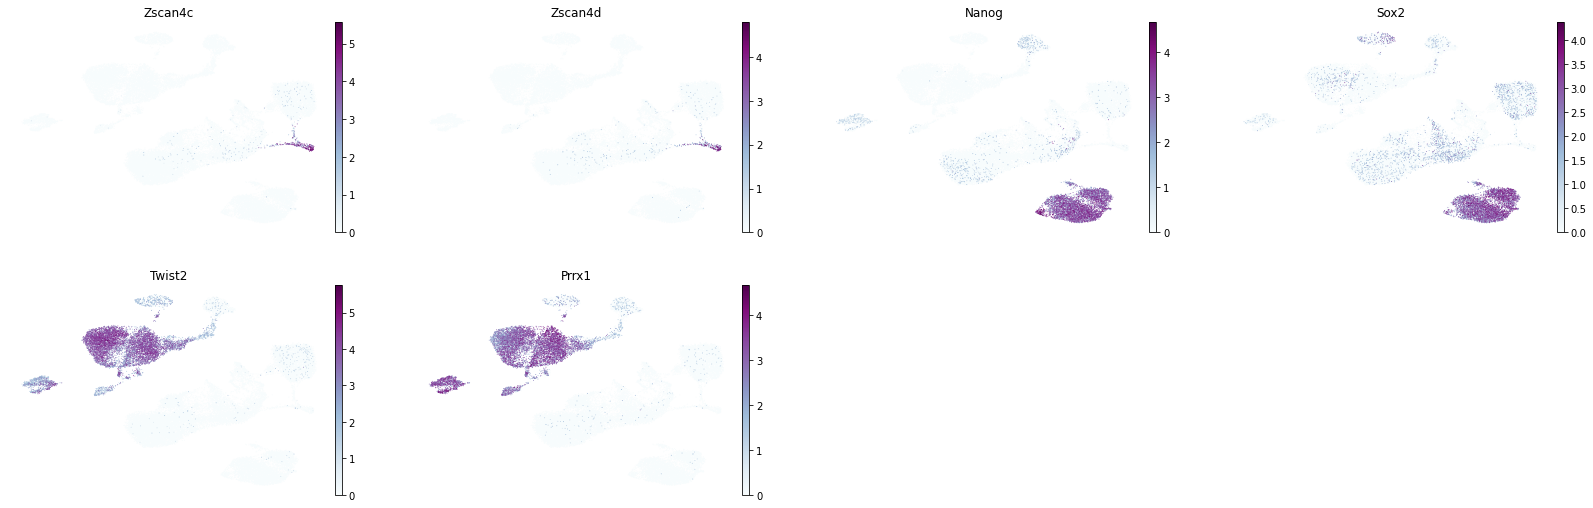

In [54]:
sc.pl.umap(adata_full, color=['Zscan4c', 'Zscan4d', 'Nanog', 'Sox2','Twist2', 'Prrx1'
                            ], frameon = False, color_map = 'BuPu')

In [99]:
ari

[0.5014403833952775,
 0.5178557790556373,
 0.5082533673143781,
 0.5187583188181623,
 0.4928122191483643,
 0.5138904316291633,
 0.511411526726286,
 0.5200868173922064,
 0.5113311719263134,
 0.49604089709746585,
 0.5201729466580991,
 0.5327970972448715,
 0.5251571389378782,
 0.49654853579197733,
 0.5053881900111576]

In [149]:
nmi

[0.667329013381085,
 0.6791694380651971,
 0.6883084550446266,
 0.691113731104972,
 0.6832748638187491,
 0.6749708015357682,
 0.6702003283997429,
 0.6775423249252961,
 0.669649706342497,
 0.6620207777476302,
 0.6787713458583691,
 0.6980322220964598,
 0.6982428531308303,
 0.6722513446149334,
 0.6692403545459357]

In [130]:
ari

[0.5258376278370113,
 0.5194684320677535,
 0.5183314336770661,
 0.5225778668453039,
 0.5238416708433455,
 0.5239493994072484,
 0.5210769798746796,
 0.5165237012331179,
 0.5255302864078824,
 0.5151578967292291,
 0.5170762252291907,
 0.5155784364911814,
 0.5305921239750717,
 0.5152317227851426,
 0.49001467876631866]

In [61]:
# tmp = adata_full.obs[adata_full.obs.leiden == '17']
# Batch = tmp.Batch.unique().tolist()
# for b in Batch:
#     cb_tmp = tmp[tmp['Batch'] == b]
#     cb_tmp = cb_tmp[['Barcode']]
# #     cb_tmp.to_csv(b + '_barcodes.tsv', header = False, index = False)

In [62]:
# var_names = {'MEF': ['Tagln','Arthur1B','ORR1D1'],
#               'XEN': ['Sox17', 'SSU-rRNA_Hsa', 'Arthur1B'],
#             'SI_D5': ['Prrx1', 'LSU-rRNA_Hsa', '(TAT)n'],
#             'SI_D12': ['Fbn1','MMVL30-int', '(TGC)n'],
#             'SII_D8': ['Dppa2','IAPLTR2b','RLTR1B-int'],
#             'SII_D12': ['Zscan4c', 'IAPLTR2_Mm','MT2_Mm'],
#             'SIII_D3': ['Zscan4d', 'IAPEz-int','MERVL-int'],
#             'SIII_D6': ['Lgals9', 'IAPLTR1_Mm', 'IAPLTR2a'],
#             'SIII_D8': ['Pou5f1', 'MT-int', 'IAPEz-int'],
#             'SIII_D10': ['Tapbp', 'IAPEY_LTR', 'IAPLTR1a_Mm'],
#             'SIII_D15': ['Sox2', 'RLTRETN_Mm', 'MMSAT4'],
#             'SIII_D21': ['Nanog', 'ETnERV-int', 'ERVB7_1-LTR_MM']}

In [63]:
# sc.pl.rank_genes_groups_dotplot(adata_full, n_genes=3, min_logfoldchange=1, values_to_plot='logfoldchanges', dot_max = 0.5, vmax=3.5, vmin=-3.5, cmap='bwr')

In [64]:
# var_names = {'MEF': ['Tagln','Arthur1B','ORR1D1'],
#               'XEN': ['Sox17', 'SSU-rRNA_Hsa', 'Arthur1B'],
#             'SI_D5': ['Prrx1', 'LSU-rRNA_Hsa', '(TAT)n'],
#             'SI_D12': ['Fbn1','MMVL30-int', '(TGC)n'],
#             'SII_D8': ['Dppa2','IAPLTR2b','RLTR1B-int'],
#             'SII_D12': ['Zscan4c', 'IAPLTR2_Mm','MT2_Mm'],
#             'SIII_D3': ['Zscan4d', 'IAPEz-int','MERVL-int'],
#             'SIII_D6': ['Lgals9', 'IAPLTR1_Mm', 'IAPLTR2a'],
#             'SIII_D8': ['Pou5f1', 'MT-int', 'IAPEz-int'],
#             'SIII_D10': ['Tapbp', 'IAPEY_LTR', 'IAPLTR1a_Mm'],
#             'SIII_D15': ['Sox2', 'RLTRETN_Mm', 'MMSAT4'],
#             'SIII_D21': ['Nanog', 'ETnERV-int', 'ERVB7_1-LTR_MM']}
# sc.pl.rank_genes_groups_dotplot(
#     adata_full,
#     var_names=var_names,
#     values_to_plot="logfoldchanges",
#     cmap='bwr',
#     dot_max = 0.15, vmax=4, vmin=-4,
#     colorbar_title='log fold change'
# )

In [65]:
# sc.pl.stacked_violin(adata_full, [ 'Zscan4c', 'Zscan4d', 'MERVL-int', 'MT2_Mm',], groupby='leiden', dendrogram=True)